In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import requests
from bs4 import BeautifulSoup
import re
from datetime import datetime
from time import mktime

In [4]:
%matplotlib inline

In [22]:
def _get_crumbs_and_cookies(stock):
    """
    get crumb and cookies for historical data csv download from yahoo finance
    
    parameters: stock - short-handle identifier of the company 
    
    returns a tuple of header, crumb and cookie
    """
    
    url = 'https://finance.yahoo.com/quote/{}/history'.format(stock)
    with requests.session():
        header = {'Connection': 'keep-alive',
                   'Expires': '-1',
                   'Upgrade-Insecure-Requests': '1',
                   'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) \
                   AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.99 Safari/537.36'
                   }
        
        website = requests.get(url, headers=header)
        soup = BeautifulSoup(website.text, 'lxml')
        crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))

        return (header, crumb[0], website.cookies)

In [58]:
def load_csv_data(stock, interval='1d', day_begin='2018-01-01', day_end='2018-09-01'):
    """
    queries yahoo finance api to receive historical data in csv file format
    
    parameters: 
        stock - short-handle identifier of the company
        
        interval - 1d, 1wk, 1mo - daily, weekly monthly data
        
        day_begin - starting date for the historical data (format: yyyy-mm-dd)
        
        day_end - final date of the data (format: yyyy-mm-dd)
    
    returns a list of comma seperated value lines
    """
    day_begin_unix = int(mktime(datetime.strptime(day_begin, '%Y-%m-%d').timetuple()))
    day_end_unix = int(mktime(datetime.strptime(day_end, '%Y-%m-%d').timetuple()))
    
    header, crumb, cookies = _get_crumbs_and_cookies(stock)
    
    with requests.session():
        url = 'https://query1.finance.yahoo.com/v7/finance/download/' \
              '{stock}?period1={day_begin}&period2={day_end}&interval={interval}&events=history&crumb={crumb}' \
              .format(stock=stock, day_begin=day_begin_unix, day_end=day_end_unix, interval=interval, crumb=crumb)
                
        website = requests.get(url, headers=header, cookies=cookies)
       
        return website.text.split('\n')[:-1]

In [59]:
stock = load_csv_data('EVO.St')

In [60]:
stock[:10]

['Date,Open,High,Low,Close,Adj Close,Volume',
 '2018-01-02,580.500000,583.000000,566.000000,569.000000,568.102356,80157',
 '2018-01-03,569.000000,581.000000,569.000000,577.000000,576.089722,67912',
 '2018-01-04,580.000000,593.000000,578.000000,588.000000,587.072388,99040',
 '2018-01-05,588.500000,592.500000,581.500000,584.000000,583.078735,36029',
 '2018-01-08,584.000000,588.500000,571.500000,585.500000,584.576355,122434',
 '2018-01-09,585.000000,607.000000,583.000000,601.000000,600.051880,115291',
 '2018-01-10,601.000000,610.000000,591.500000,608.500000,607.540039,85975',
 '2018-01-11,610.000000,619.000000,598.000000,601.500000,600.551086,132103',
 '2018-01-12,602.000000,631.000000,602.000000,626.500000,625.511658,137492']

In [4]:
def get_data(stock):
    df = pd.read_csv('/Users/alexandersson/Downloads/' + stock, parse_dates=['Date'], index_col=['Date'])
    return df

In [5]:
def moving_average(df, periods):
    df['MA'+str(periods)] = df['Close'].rolling(window=periods).mean()

In [6]:
def plotter(df, MA50=False, MA200=False):
    plt.figure(figsize=(15,5))
    plt.subplot(211)
    plt.plot(df['Close'])
    if MA50:
        moving_average(df, 50)
        plt.plot(df['MA50'])
    if MA200:
        moving_average(df, 200)
        plt.plot(df['MA200'])
    plt.legend(['Close', 'MA50', 'MA200'])
    plt.subplot(212)
    plt.plot(df['Volume'])
    plt.legend(['Volym'], loc=2)

In [7]:
EVO = get_data('EVO.ST.csv')
SKA = get_data('SKA-B.ST.csv')
ENG = get_data('ENG.ST.csv')

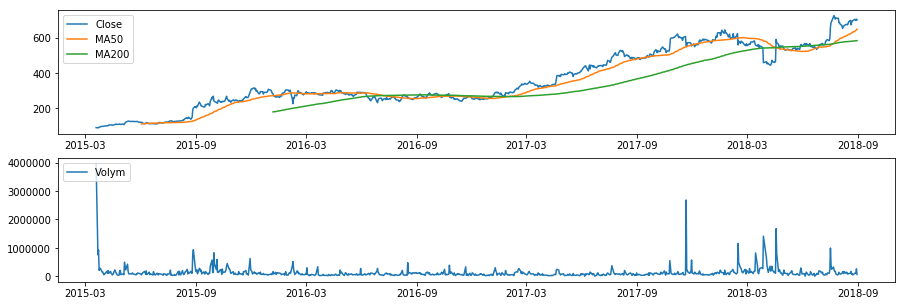

In [8]:
plotter(EVO, MA50=True, MA200=True)

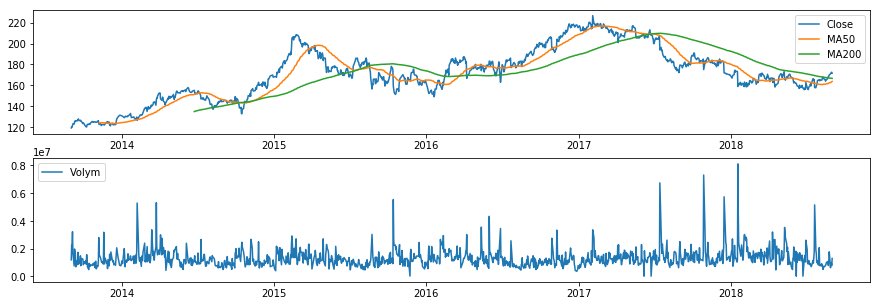

In [9]:
plotter(SKA, MA50=True, MA200=True)

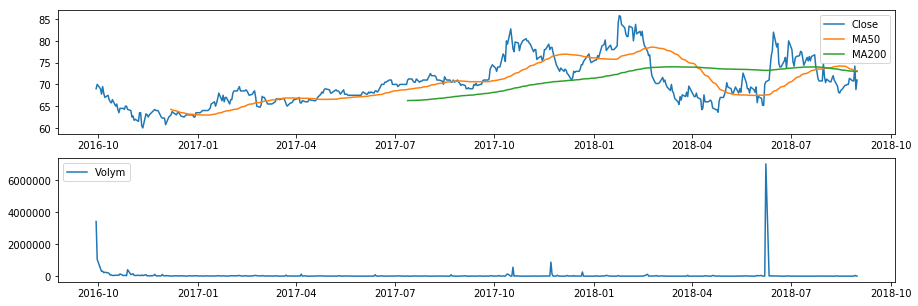

In [10]:
plotter(ENG, True, True)

In [11]:
s2 = SKA.groupby([SKA.index.year])['Volume'].sum()

In [12]:
s2

Date
2013     97114564
2014    318821990
2015    320496240
2016    312018910
2017    353422131
2018    254445316
Name: Volume, dtype: int64

In [13]:
ska_monthly_vol = SKA['Volume'].resample('M').sum()

In [14]:
ska_monthly_vol.head()

Date
2013-09-30    30005131
2013-10-31    20614350
2013-11-30    25109052
2013-12-31    21386031
2014-01-31    25684136
Freq: M, Name: Volume, dtype: int64

In [19]:
SKA.tail()

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200
Date,,,,,,,,
2018-08-27,170.000000,171.350006,169.949997,171.100006,171.100006,612228,162.754001,166.97200
2018-08-28,171.000000,171.949997,170.600006,171.600006,171.600006,900349,163.014001,166.91650
2018-08-29,171.100006,173.050003,171.100006,172.449997,172.449997,981386,163.261001,166.87025
2018-08-30,171.949997,173.449997,171.750000,172.550003,172.550003,766724,163.555001,166.81950
2018-08-31,172.500000,172.850006,171.199997,171.699997,171.699997,1281933,163.832001,166.76550


In [26]:
SKA.loc['2018-08-27':'2018-08-31']

,Open,High,Low,Close,Adj Close,Volume,MA50,MA200
Date,,,,,,,,
2018-08-27,170.000000,171.350006,169.949997,171.100006,171.100006,612228,162.754001,166.97200
2018-08-28,171.000000,171.949997,170.600006,171.600006,171.600006,900349,163.014001,166.91650
2018-08-29,171.100006,173.050003,171.100006,172.449997,172.449997,981386,163.261001,166.87025
2018-08-30,171.949997,173.449997,171.750000,172.550003,172.550003,766724,163.555001,166.81950
2018-08-31,172.500000,172.850006,171.199997,171.699997,171.699997,1281933,163.832001,166.76550


In [61]:
evo=load_csv_data('evo.st', day_begin='2018-01-01', day_end='2018-09-11')

In [69]:
evo_df = pd.DataFrame(s.split(',') for s in evo)

In [70]:
evo_df.head()

,0,1,2,3,4,5,6
0,Date,Open,High,Low,Close,Adj Close,Volume
1,2018-01-02,580.500000,583.000000,566.000000,569.000000,568.102356,80157
2,2018-01-03,569.000000,581.000000,569.000000,577.000000,576.089722,67912
3,2018-01-04,580.000000,593.000000,578.000000,588.000000,587.072388,99040
4,2018-01-05,588.500000,592.500000,581.500000,584.000000,583.078735,36029


In [71]:
evo_df.tail()

,0,1,2,3,4,5,6
173,2018-09-05,677.000000,679.500000,655.000000,656.000000,656.000000,131549
174,2018-09-06,655.000000,666.000000,650.000000,653.500000,653.500000,131291
175,2018-09-07,653.000000,659.000000,645.000000,656.500000,656.500000,59731
176,2018-09-10,657.500000,661.000000,647.000000,655.500000,655.500000,52523
177,2018-09-11,655.500000,657.500000,647.500000,654.000000,654.000000,55544
